


# LatentVisions


> "I was afraid that not a
single thing on earth would ever again surprise me"

-Jorge Luis Borges



---




#### What is this?

This is a notebook that uses Taming Transformers and CLIP to generate images from text. 

Feel free to send correspondence to [@advadnoun](https://twitter.com/advadnoun) on Twitter. This notebook is for non-commercial use unless specified. If you do use this for a non-commercial project, just link to my twtter profile :)



---



# How do I use this?

First, type in your description(s) where it says *A beautiful Waluigi* or upload image(s) and enter their path. You can add multiple text and image paths, and/or you can leave them blank. 

Next, decide how much weight you want each text and image to have on the output by adjusting the `w` variables -- it is suggested that you set at least one weight to 1.

Finally, click **Runtime** up in the top menu and choose **Run All**, then wait as each sequential play button circles around.

Your output will appear at the bottom of this page near the **Train** heading as it processes after a short while. Scroll down below everything else to see new images appear. 

The images will start by looking like dirt, but the page will eventually ding and show new images as it begins to attempt to match the image to your inputs.


# Params

Fill in the texts and image paths.

To upload images, just click this button: 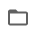 then drag them into the left pane.
Images default to being uploaded to `/content/<image_name.png>`. 



In [ ]:
#@title Start Here :) { display-mode: "form" }
text_input = "A beautiful Waluigi" #@param {type:"string"}
w0 = 1 #@param {type:"slider", min:-5, max:5, step:0.1}
text_to_add = "" #@param {type:"string"}
w1 = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
img_enc_path = "/content/MonetLisa.jpg" #@param {type:"string"}
w2 = 1 #@param {type:"slider", min:-5, max:5, step:0.1}
ne_img_enc_path = "" #@param {type:"string"}
w3 = 0 #@param {type:"slider", min:-5, max:5, step:0.1}

# How to weight the 2 texts (w0 and w1) and the images (w3 & w3)


im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape
batch_size = 1


# GPU information

In [ ]:
# were you lucky today?

!nvidia-smi -L


GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-8f71be65-0b97-ff37-5121-9e3171d0517a)


# Top (imports)


In [ ]:
# don't use half of these lol

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
!pip install kornia
import kornia

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



# Perceptor

In [ ]:
!pip install --no-deps ftfy regex tqdm
!git clone https://github.com/openai/CLIP.git

#Modify CLIP to output patches
# import fileinput
# with fileinput.FileInput('CLIP/clip/model.py', inplace=True, backup='.bak') as file:
#     for line in file:
#         print(line.replace("x = self.ln_post(x[:, 0, :])", "x = self.ln_post(x[:, :, :])"), end='')

#Import CLIP and load the model
from CLIP import clip
perceptor, preprocess = clip.load('ViT-B/32', jit=False)
perceptor.eval()

clip.available_models()

perceptor.visual.input_resolution

scaler = 1
# perceptor.visual.scale = 224*scaler
# # perceptor.visual.positional_embedding = torch.nn.Parameter(torch.cat([perceptor.visual.positional_embedding]*5 + [perceptor.visual.positional_embedding[:7]]))



# # pos_ed = []
# # for p in range(1, len(perceptor.visual.positional_embedding)):
# #   # pos_ed.append((perceptor.visual.positional_embedding.data[p//4] + perceptor.visual.positional_embedding.data[p//4 + 1]) / 2)
# #   pos_ed.append((perceptor.visual.positional_embedding.data[[p]]))
# #   pos_ed.append((perceptor.visual.positional_embedding.data[[p]]))
# #   pos_ed.append((perceptor.visual.positional_embedding.data[[p]]))
# #   pos_ed.append((perceptor.visual.positional_embedding.data[[p]]))

# # perceptor.visual.positional_embedding.shape

# thems = torchvision.transforms.Resize((scaler*7, scaler*7), interpolation=torchvision.transforms.InterpolationMode.BILINEAR)(perceptor.visual.positional_embedding.data[1:].T.view(1, 768, 7, 7))

# # thems = perceptor.visual.positional_embedding.data[1:].T.repeat_interleave(scaler**2).view(1, 768, 7*scaler, 7*scaler)

# thems = thems.permute(0, 2, 3, 1).view(-1, 768)

# perceptor.visual.positional_embedding = torch.nn.Parameter(torch.cat([perceptor.visual.positional_embedding.data[:1], thems]))

# # perceptor.visual.positional_embedding.shape



fatal: destination path 'CLIP' already exists and is not an empty directory.


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


CLIP(
  (visual): VisualTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((7

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']

224

# Define

In [ ]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Generator

In [ ]:
!pip uninstall torchtext --yes

!pip install einops


%cd /content/
!git clone https://github.com/CompVis/taming-transformers  
%cd /content/taming-transformers


# download a VQGAN with a larger codebook (16384 entries)
!mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_16384/configs

if len(os.listdir('logs/vqgan_imagenet_f16_16384/checkpoints/')) == 0:
  !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
  !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml' 



# !cp /content/drive/MyDrive/vqgan_imagenet_f16_16384-20210325T002625Z-001.zip /content/vq.zip
# !unzip /content/vq.zip -d /content/taming-transformers/logs/


%pip install omegaconf==2.0.0 pytorch-lightning==1.0.8
import sys
sys.path.append(".")


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None):
  model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)
model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

%cd /content/


/content
fatal: destination path 'taming-transformers' already exists and is not an empty directory.
/content/taming-transformers
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [ ]:
# with torch.no_grad():
#   x = torch.nn.functional.interpolate(.5*torch.rand(size=(batch_size, 3, sideX//1, sideY//1)).cuda(), (sideX, sideY), mode='bilinear')
#   # x = kornia.augmentation.GaussianBlur((7, 7), (14, 14), p=1)(x)
#   # x = (torch.nn.functional.interpolate(torch.tensor(imageio.imread('/content/itme.jpg')).unsqueeze(0).permute(0, 3, 1, 2), (sideX, sideY)) / 255).cuda()
#   x = (x * 2 - 1)
#   o_i1 = model16384.encoder(x)
#   o_i2 = model16384.quant_conv(o_i1)
#   # o_i3 = model16384.post_quant_conv(o_i2)

# # # plt.hist(o_i1.detach().cpu().flatten().numpy())
# # # plt.show()
# # # plt.close()
# # # plt.hist(o_i2.detach().cpu().flatten().numpy())
# # # plt.show()
# # # plt.close()
# # # plt.hist(o_i3.detach().cpu().flatten().numpy())

 # Latent coordinate & Text

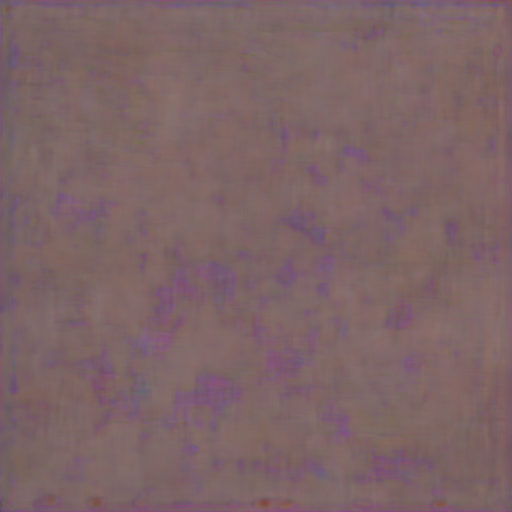

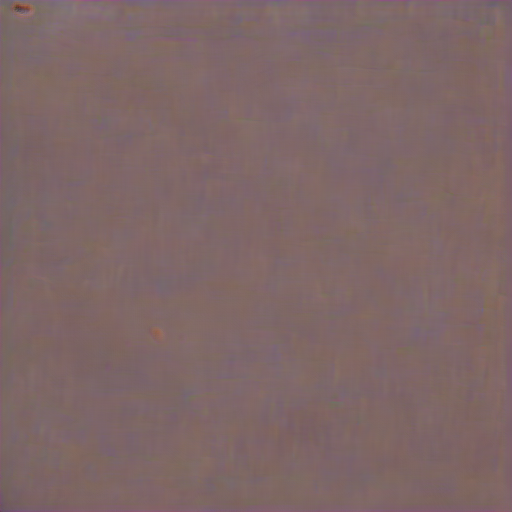

In [ ]:
torch.cuda.empty_cache()





#. A detailed, high-quality photo without distortions



text_other = '''incoherent, confusing, cropped, watermarks'''


class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()


        # self.normu = torch.nn.Parameter(o_i2.cuda().clone())

        self.normu = .5*torch.randn(batch_size, 256, sideX//16, sideY//16).cuda()
        
        self.normu = torch.nn.Parameter(torch.sinh(1.9*torch.arcsinh(self.normu)))

    def forward(self):


      return self.normu.clip(-6, 6)
      

def model(x):
  # o_i1 = model16384.encoder(x)
  # o_i1 = x
  # o_i2 = model16384.quant_conv(o_i1)
  o_i2 = x
  o_i3 = model16384.post_quant_conv(o_i2)
  i = model16384.decoder(o_i3)
  return i


dec = .1

lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.AdamW([{'params': mapper, 'lr': .5}], weight_decay=dec)
eps = 0

t = 0
if text_input != '':
  tx = clip.tokenize(text_input)
  t = perceptor.encode_text(tx.cuda()).detach().clone()

text_add = 0
if text_to_add != '':
  text_add = clip.tokenize(text_to_add)
  text_add = perceptor.encode_text(text_add.cuda()).detach().clone()

t_not = clip.tokenize(text_other)
t_not = perceptor.encode_text(t_not.cuda()).detach().clone()


nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

img_enc = 0
if img_enc_path != '':
  img_enc = (torch.nn.functional.interpolate(torch.tensor(imageio.imread(img_enc_path)).unsqueeze(0).permute(0, 3, 1, 2), (224, 224)) / 255).cuda()[:,:3]
  img_enc = nom(img_enc)
  img_enc = perceptor.encode_image(img_enc.cuda()).detach().clone()

ne_img_enc = 0
if ne_img_enc_path != '':
  ne_img_enc = (torch.nn.functional.interpolate(torch.tensor(imageio.imread(ne_img_enc_path)).unsqueeze(0).permute(0, 3, 1, 2), (224, 224)) / 255).cuda()[:,:3]
  ne_img_enc = nom(ne_img_enc)
  ne_img_enc = perceptor.encode_image(ne_img_enc.cuda()).detach().clone()



augs = torch.nn.Sequential(
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(24, (.1, .1), fill=0)
).cuda()


up_noise = .11



itt = 0


with torch.no_grad():
  al = (model(lats()).cpu().clip(-1, 1) + 1) / 2
  for allls in al:
    displ(allls[:3])
    print('\n')
    


# Train

In [ ]:
#@title Your images should appear below here shortly!

def augment(into, cutn=32):

  into = torch.nn.functional.pad(into, (sideX//2, sideX//2, sideX//2, sideX//2), mode='constant', value=0)


  into = augs(into)

  p_s = []
  for ch in range(cutn):
    # size = torch.randint(int(.5*sideX), int(1.9*sideX), ())
    size = int(torch.normal(1.2, .3, ()).clip(.43, 1.9) * sideX)
    
    if ch > cutn - 4:
      size = int(sideX*1.4)
    offsetx = torch.randint(0, int(sideX*2 - size), ())
    offsety = torch.randint(0, int(sideX*2 - size), ())
    apper = into[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (int(224*scaler), int(224*scaler)), mode='bilinear', align_corners=True)
    p_s.append(apper)
  into = torch.cat(p_s, 0)

  into = into + up_noise*torch.rand((into.shape[0], 1, 1, 1)).cuda()*torch.randn_like(into, requires_grad=False)

  return into

def checkin(loss):
  global up_noise
  
  with torch.no_grad():
    
    alnot = model(lats()).float()
    alnot = augment((((alnot).clip(-1, 1) + 1) / 2), cutn=1)
    for allls in alnot.cpu():
      displ(allls)
      display.display(display.Image(str(3)+'.png'))
      print('\n')


    print('''
    @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    ''')


    alnot = (model(lats()).cpu().clip(-1, 1) + 1) / 2
    
    for allls in alnot.cpu():
      displ(allls) #[:, int(.1*sideY):int(.9*sideY), int(.1*sideX):int(.9*sideX)]
      display.display(display.Image(str(3)+'.png'))
      print('\n')

  
  print('''
  ##########################################################
  ''',
        loss, ' loss\niteration',itt)


  # the people spoke and they love "ding"
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  global up_noise
  out = model(lats())


  into = augment((out.clip(-1, 1) + 1) / 2)



  into = nom(into)


  iii = perceptor.encode_image(into)

  # q = slerp(.2, t, img_enc)

  q = w0*t + w1*text_add + w2*img_enc + w3*ne_img_enc
  q = q / q.norm(dim=-1, keepdim=True)

  all_s = torch.cosine_similarity(q, iii, -1)

  return [0, -10*all_s + 5 * torch.cosine_similarity(t_not, iii, -1)]
  
def train(i):
  global dec
  global up_noise

  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  



  # if itt > 400:
  #   for g in optimizer.param_groups:
  #     g['lr'] *= .995
  #     g['lr'] = max(g['lr'], .1)
  #   dec *= .995



  if torch.abs(lats()).max() > 5:
    for g in optimizer.param_groups:
      g['weight_decay'] = dec
  else:
    for g in optimizer.param_groups:
      g['weight_decay'] = 0
  
  if itt % 100 == 0:
    checkin(loss1)
    
    print('up_noise', up_noise)
    for g in optimizer.param_groups:
      print(g['lr'], 'lr', g['weight_decay'], 'decay')


def loop():
  global itt
  for asatreat in range(700000):
    train(itt)
    itt+=1

loop()


In [ ]:
checkin(0)

#### Thanks!

Many thanks to OpenAI for releasing their models CLIP and DALL-E (the encoder and decoder parts, specifically). I am not affiliated with them.


https://github.com/openai/DALL-E/ (Aditya Ramesh, Mikhail Pavlov, Gabriel Goh, Scott Gray, Chelsea Voss, Alec Radford, Mark Chen, Ilya Sutskever)

https://github.com/openai/CLIP (Alec Radford, \* Jong Wook Kim,\* Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal,
Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever)

Also, as a good launching point for future directions and to find more related work, see https://distill.pub/2017/feature-visualization/ by Chris Olah, Alexander Mordvintsev, Ludwig Schubert.

Thanks to to Patrick Esser\* Robin Rombach\* Bjorn Ommer for the VQGAN in Taming Transformers! https://github.com/CompVis/taming-transformers

\* equal contribution


---


**Also massive thanks to my patrons and contributors on the Discord who support me**. You'll also see that alstroemeria313 (https://twitter.com/RiversHaveWings), CobaltOwl, and Johanezz have contributed the suggestions of weight decay and random-encoded images specifically.

Thanks to ZoeOzone for the title of this notebook: https://twitter.com/zoebot_zoe

Thanks to hotgrits for loading CLIP without restarting. http://torridgristle.tumblr.com/

Props to spruce (https://twitter.com/kingchloexx), who did previous work on adding encoded text to an encoded image using Aleph.

Haltakov's post & notebook introduced me to CLIP arythmetic: https://twitter.com/advadnoun/status/1386742901300817920

